In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

In [8]:
from nltk.corpus import twitter_samples
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [9]:
pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')

In [10]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [12]:
df = pd.DataFrame({'tweet': pos_tweets + neg_tweets, 'sentiment': [1] * len(pos_tweets) + [0] * len(neg_tweets)})

In [13]:
df['cleaned_text'] = df['tweet'].apply(lambda x: ' '.join(process_tweet(x)))

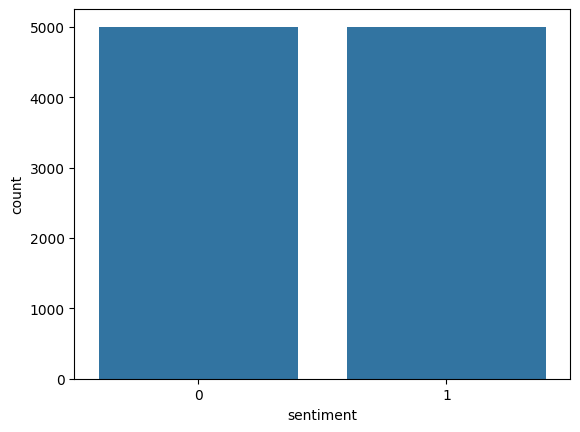

In [14]:
sns.countplot(x=df['sentiment'])
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12299 (\N{RIGHT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


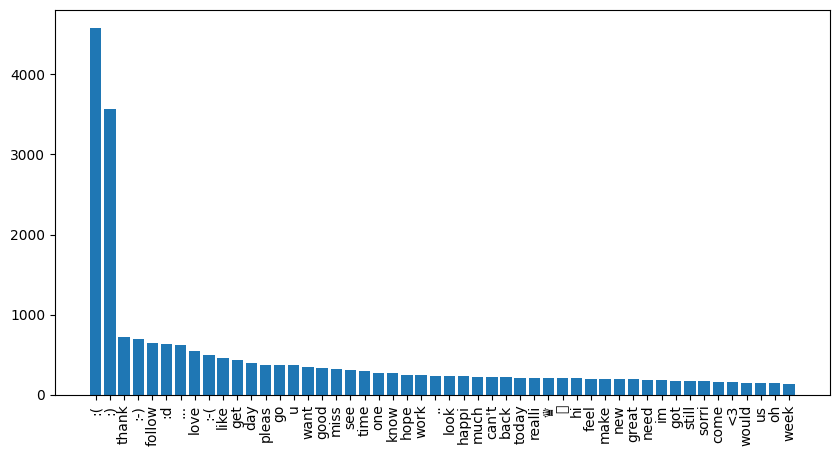

In [15]:
from collections import Counter
words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(words)
word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
x, y = zip(*word_freq[:50])
plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

count_vec = CountVectorizer()
X = count_vec.fit_transform(df['cleaned_text'])

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['cleaned_text'])

In [17]:
!pip install gensim

In [18]:
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(df['cleaned_text'])]
d2v_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=20)
X_doc2vec = np.array([d2v_model.infer_vector(doc.split()) for doc in df['cleaned_text']])

In [19]:
from gensim.models.phrases import Phrases,Phraser
phrases = Phrases(df['cleaned_text'].apply(str.split))
bigram = Phraser(phrases)
df['bigram_text'] = df['cleaned_text'].apply(lambda x:' '.join(bigram[x.split()]))

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_tfidf.toarray())

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train,X_test,Y_train,Y_test = train_test_split(X_tfidf,df['sentiment'],test_size=0.2,random_state=42)
model1 = LogisticRegression()
model1.fit(X_train,Y_train)
y_pred = model1.predict(X_test)
print(classification_report(Y_test,y_pred))


              precision    recall  f1-score   support

           0       0.72      0.78      0.75       988
           1       0.76      0.71      0.74      1012

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



In [22]:
from sklearn.metrics import accuracy_score
accuracy_logistic = accuracy_score(Y_test, model1.predict(X_test))

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model2 = Sequential([
    Dense(128, activation='relu',input_shape=(X_tfidf.shape[1],)),
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')
])
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model2.fit(X_train.toarray(),Y_train,epochs=5,batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.6415 - loss: 0.6304
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8718 - loss: 0.3225
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9232 - loss: 0.1954
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9560 - loss: 0.1230
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9651 - loss: 0.0882


In [24]:
accuracy_nn = model2.evaluate(X_test.toarray(), Y_test, verbose=0)[1]

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [26]:
df['sentiment'].describe()

,sentiment
count,10000.000000
mean,0.500000
std,0.500025
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


nb_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

nb_pipeline.fit(df['tweet'], df['sentiment'])

def predict_sentiment(text, model):
    return model.predict([text])[0]
def calculate_accuracy(df, model):
    predictions = model.predict(df['tweet'])
    accuracy = accuracy_score(df['sentiment'], predictions)
    return accuracy

accuracy_nb = calculate_accuracy(df, nb_pipeline)



In [37]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

start_time = time.time()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

classifier = pipeline(
    task="sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    device=0 if torch.cuda.is_available() else -1
)


def get_sentiment_label(result):
    if result['label'] == 'POSITIVE':
        return 1
    else:
        return 0

batch_size = 16
test_predictions = []

for i in range(0, len(test_df), batch_size):
    batch = test_df['tweet'][i:i+batch_size].tolist()
    results = classifier(batch)
    predictions = [get_sentiment_label(result) for result in results]
    test_predictions.extend(predictions)

# Calculate metrics
elapsed_time = time.time() - start_time
accuracy = accuracy_score(test_df['sentiment'].tolist(), test_predictions)

Device set to use cpu


In [38]:
print(accuracy)

0.666


In [33]:
print(accuracy_nb)

0.9304


In [34]:
print(accuracy_nn)

0.7164999842643738


In [39]:
print(accuracy_logistic)

0.7425


In [40]:
models = ["Logistic Regression", "Naive Bayes", "NN", "BERT"]
accuracies = [accuracy_logistic, accuracy_nb, accuracy_nn, accuracy]

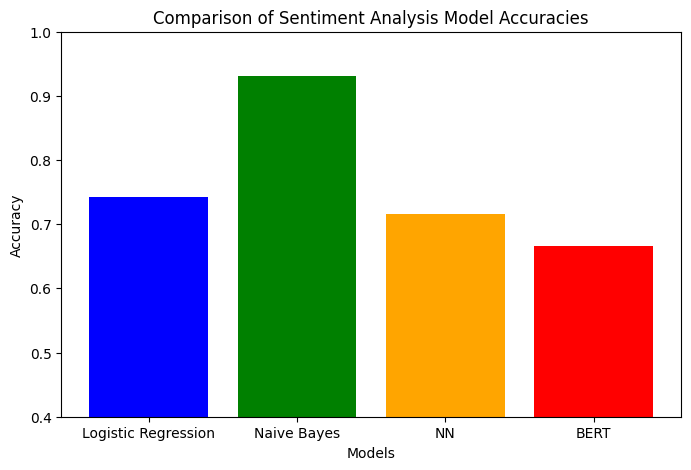

In [42]:
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0.4, 1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Sentiment Analysis Model Accuracies")
plt.show()